In [1]:
import os
from datetime import datetime

import IPython
import IPython.display

import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer

#custom functions import
from finance_formula import rsi


#plotting setting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


#pytorch 
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

c:\Users\Vincent\.conda\envs\Pytorch_1_11\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = "training_log/newframe_sm_ma_rsi_hs300_29_7win.csv"

In [4]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, r"stock_data\index300_05_22_day.csv")

# Data Preprocessing

In [5]:
drop_list = ['change']

df = pd.read_csv(filename).drop(drop_list, axis=1)

In [6]:
if debug_mode == True:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,600783.SH,20221215,13.63,13.63,13.38,13.58,13.55,0.2214,38397.67,51819.5570
1,600783.SH,20221214,13.54,13.82,13.42,13.55,13.46,0.6686,57557.68,78307.7080
2,600783.SH,20221213,13.12,13.65,13.10,13.46,13.24,1.6616,74087.26,99829.4500
3,600783.SH,20221212,13.25,13.46,13.04,13.24,13.29,-0.3762,60428.45,79917.9930
4,600783.SH,20221209,13.56,13.60,13.19,13.29,13.53,-1.7738,66449.00,88408.6250
...,...,...,...,...,...,...,...,...,...,...
1743021,002064.SZ,20060829,9.60,9.79,9.50,9.65,9.63,0.2100,58861.23,56827.0509
1743022,002064.SZ,20060828,9.61,9.91,9.42,9.63,9.54,0.9400,75694.74,73239.1825
1743023,002064.SZ,20060825,9.22,10.00,9.13,9.54,9.28,2.8000,121564.97,115534.6703
1743024,002064.SZ,20060824,8.91,9.37,8.85,9.28,9.18,1.0900,110143.17,100371.4400


In [7]:
#split data into different stock
# stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]

stock_list = []

for ts_code, x in df.groupby('ts_code'):
    stock_list.append(x.copy().sort_values("trade_date", ascending = True).reset_index().drop('index', axis=1))




#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

number of stocks :  577


In [8]:
#add hs300 as a proxy

hs300_filename = os.path.join(fileDir, r"stock_data\hs300index_05_22_day.csv")

df_hs300 = pd.read_csv(hs300_filename).drop(['index_ts_code', 'index_vol', 'index_change', 'index_amount'], axis=1).sort_values("index_trade_date", ascending = True)

display(df_hs300)

,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [9]:
stock_list[2]['trade_date']
print(len(stock_list[2]['trade_date']))

tx = df_hs300[df_hs300['index_trade_date'].isin(stock_list[2]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
display(tx)

display(stock_list[2])

display(df_hs300)

txp = pd.concat([stock_list[2], tx], axis=1, join='inner')
display(txp)

3919


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
3914,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3915,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
3916,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3917,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,000008.SZ,20050509,5.89,6.10,5.29,5.29,5.88,-10.0300,15363.61,8531.0565
1,000008.SZ,20050510,5.19,5.24,4.85,5.14,5.29,-2.8400,13096.90,6571.2745
2,000008.SZ,20050511,5.08,5.34,5.06,5.13,5.14,-0.1900,13298.00,6937.8679
3,000008.SZ,20050512,5.13,5.32,5.06,5.23,5.13,1.9500,9775.74,5111.7443
4,000008.SZ,20050513,5.34,5.75,5.25,5.75,5.23,9.9400,22874.01,12752.0454
...,...,...,...,...,...,...,...,...,...,...
3914,000008.SZ,20221209,2.51,2.54,2.48,2.50,2.52,-0.7937,242420.92,60641.4020
3915,000008.SZ,20221212,2.50,2.50,2.44,2.46,2.50,-1.6000,219788.92,54104.7550
3916,000008.SZ,20221213,2.45,2.48,2.45,2.47,2.46,0.4065,153038.00,37742.1110
3917,000008.SZ,20221214,2.48,2.48,2.41,2.42,2.47,-2.0243,222385.00,54181.2000


,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
4285,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
4284,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
4283,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
4282,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4281,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...
4,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
2,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
1,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_trade_date,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000008.SZ,20050509,5.89,6.10,5.29,5.29,5.88,-10.0300,15363.61,8531.0565,20050509,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,000008.SZ,20050510,5.19,5.24,4.85,5.14,5.29,-2.8400,13096.90,6571.2745,20050510,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,000008.SZ,20050511,5.08,5.34,5.06,5.13,5.14,-0.1900,13298.00,6937.8679,20050511,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,000008.SZ,20050512,5.13,5.32,5.06,5.23,5.13,1.9500,9775.74,5111.7443,20050512,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,000008.SZ,20050513,5.34,5.75,5.25,5.75,5.23,9.9400,22874.01,12752.0454,20050513,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,000008.SZ,20221209,2.51,2.54,2.48,2.50,2.52,-0.7937,242420.92,60641.4020,20221209,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
3915,000008.SZ,20221212,2.50,2.50,2.44,2.46,2.50,-1.6000,219788.92,54104.7550,20221212,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
3916,000008.SZ,20221213,2.45,2.48,2.45,2.47,2.46,0.4065,153038.00,37742.1110,20221213,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
3917,000008.SZ,20221214,2.48,2.48,2.41,2.42,2.47,-2.0243,222385.00,54181.2000,20221214,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [10]:
#concat

for i in range(len(stock_list)):

    temp = df_hs300[df_hs300['index_trade_date'].isin(stock_list[i]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
    stock_list[i] = pd.concat([stock_list[i], temp], axis=1, join='inner').drop('index_trade_date', axis=1)




In [11]:
display(stock_list[3])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000009.SZ,20050509,2.65,2.68,2.52,2.53,2.66,-4.8900,16053.15,4156.8566,909.1740,934.6500,937.3900,909.1740,932.3950,-2.4905
1,000009.SZ,20050510,2.53,2.58,2.44,2.55,2.53,0.7900,20829.41,5235.9416,913.0760,905.5430,913.3880,892.3130,909.1740,0.4292
2,000009.SZ,20050511,2.55,2.66,2.51,2.59,2.55,1.5700,27403.02,7103.4251,901.8510,911.8380,917.2230,900.4380,913.0760,-1.2294
3,000009.SZ,20050512,2.56,2.60,2.47,2.48,2.59,-4.2500,18046.36,4552.7859,885.8200,899.9680,900.0630,883.5110,901.8510,-1.7776
4,000009.SZ,20050513,2.47,2.56,2.46,2.52,2.48,1.6100,16437.64,4122.7014,887.5430,883.5050,898.5050,875.5760,885.8200,0.1945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080,000009.SZ,20221209,13.57,13.67,13.33,13.33,13.70,-2.7007,718855.04,963415.9290,3998.2442,3961.9919,4003.3178,3944.4396,3959.1798,0.9867
4081,000009.SZ,20221212,13.23,13.26,12.97,13.10,13.33,-1.7254,396017.65,518509.2920,3953.4433,3976.1722,3983.4332,3950.3203,3998.2442,-1.1205
4082,000009.SZ,20221213,13.08,13.18,12.86,12.95,13.10,-1.1450,329622.46,428539.1200,3945.6813,3953.5482,3964.3957,3939.9795,3953.4433,-0.1963
4083,000009.SZ,20221214,12.98,13.07,12.81,12.91,12.95,-0.3089,225046.34,290139.0380,3954.8857,3952.7885,3972.7381,3935.7668,3945.6813,0.2333


In [12]:
display(stock_list[0][0:15])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,index_low,index_close,index_pre_close,index_pct_chg
0,000001.SZ,20050509,6.23,6.27,5.98,6.09,6.20,-1.77,96939.11,59428.4874,909.174,934.650,937.390,909.174,932.395,-2.4905
1,000001.SZ,20050510,6.09,6.36,5.97,6.31,6.09,3.61,108414.13,67332.3061,913.076,905.543,913.388,892.313,909.174,0.4292
2,000001.SZ,20050511,6.28,6.40,6.12,6.19,6.31,-1.90,106868.37,66813.6905,901.851,911.838,917.223,900.438,913.076,-1.2294
3,000001.SZ,20050512,6.18,6.34,6.14,6.19,6.19,0.00,79396.48,49387.0372,885.820,899.968,900.063,883.511,901.851,-1.7776
4,000001.SZ,20050513,6.19,6.24,5.90,6.02,6.19,-2.75,111481.38,67292.1901,887.543,883.505,898.505,875.576,885.820,0.1945
5,000001.SZ,20050516,6.02,6.02,5.76,5.90,6.02,-1.99,54461.62,32003.5853,875.271,885.389,885.389,869.334,887.543,-1.3827
6,000001.SZ,20050517,5.90,6.15,5.81,6.06,5.90,2.71,60944.28,36815.7997,881.462,873.077,888.281,868.212,875.271,0.7073
7,000001.SZ,20050518,6.06,6.20,6.04,6.14,6.06,1.32,52046.44,31843.2828,883.196,881.141,890.403,871.821,881.462,0.1967
8,000001.SZ,20050519,6.14,6.27,6.01,6.20,6.14,0.98,72994.06,45054.1898,884.171,882.842,888.016,871.289,883.196,0.1104
9,000001.SZ,20050520,6.22,6.34,6.12,6.21,6.20,0.16,98810.85,61928.4089,882.763,883.513,891.020,879.180,884.171,-0.1592


## add time periodicity

In [13]:
#setup timestamp for year periodicity 
date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

In [14]:
if debug_mode:
    print(date_time_db[0])

0      2005-05-09
1      2005-05-10
2      2005-05-11
3      2005-05-12
4      2005-05-13
          ...    
4135   2022-12-09
4136   2022-12-12
4137   2022-12-13
4138   2022-12-14
4139   2022-12-15
Name: trade_date, Length: 4140, dtype: datetime64[ns]


In [15]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [16]:
if debug_mode:
    date_time_stamp_db[0]

In [17]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

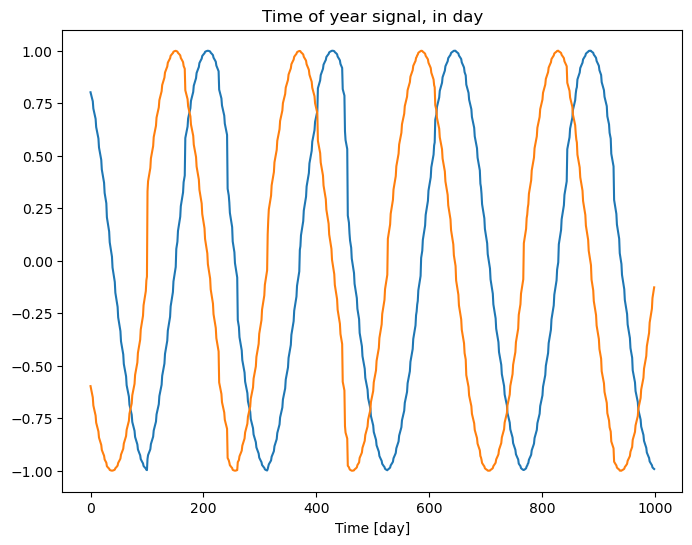

In [18]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [19]:
if debug_mode:
    stock_list[5].head()

In [20]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    #stock.pop("pre_close") #pop previous day close price

In [21]:
if debug_mode:
    stock_list[0].head()

## Financial features implementation

In [22]:
ma_label = 'open'

In [23]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()



    #rsi implementation
    stock['rsi'] = rsi(stock)

    

    # # Golden Cross  implementation
    # np.where(stock['ema20'] > stock['ema50'], 1, 0)

    # stock['ema20_50_GC'] = 0 

    # for i in range(stock.shape[0]):
    #     if i == 0:
    #         pass
    #     elif stock['ema20'][i] >= stock['ema50'][i] and stock['ema20'][i-1] < stock['ema50'][i-1]: #slow code, works for now
    #         stock['ema20_50_GC'][i] = 1



    stock.dropna(inplace=True)
    

In [24]:
# #GC value count inspction
# for stock in stock_list:
#     print(stock['ema20_50_GC'].value_counts())



In [25]:
display(stock_list[0])

,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,...,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50,rsi
14,6.14,6.28,6.12,6.15,6.14,0.1600,54319.51,3.366851e+04,849.5080,855.5950,...,848.3980,857.3310,-0.9125,0.581988,-0.813198,6.112,6.129532,6.120155,6.122074,52.264105
15,6.10,6.15,5.90,6.10,6.15,-0.8100,58045.27,3.502850e+04,855.6120,847.6340,...,842.1020,849.5080,0.7185,0.539264,-0.842137,6.106,6.119673,6.117750,6.120243,49.149742
16,6.10,6.16,5.95,6.01,6.10,-1.4800,59995.22,3.630594e+04,855.9460,856.5610,...,853.2910,855.6120,0.0390,0.524697,-0.851289,6.136,6.113108,6.115683,6.118634,44.060298
17,6.01,6.04,5.93,5.95,6.01,-1.0000,38591.03,2.304762e+04,837.5320,855.2060,...,836.0400,855.9460,-2.1513,0.509976,-0.860189,6.102,6.078716,6.103628,6.110335,41.011372
18,5.95,6.02,5.70,5.78,5.95,-2.8600,78764.74,4.588484e+04,818.3790,835.4670,...,812.9890,837.5320,-2.2868,0.495104,-0.868834,6.060,6.035791,6.086428,6.098524,33.861640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,...,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.262,13.228249,12.484849,12.083849,70.110410
4136,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,...,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.360,13.345499,12.589149,12.142521,59.472356
4137,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,...,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.322,13.280333,12.642563,12.182030,60.880819
4138,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,...,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.302,13.263555,12.698510,12.223127,60.706049


# Final data check

In [26]:
display(stock_list[0])
display(stock_list[50])

,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,...,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50,rsi
14,6.14,6.28,6.12,6.15,6.14,0.1600,54319.51,3.366851e+04,849.5080,855.5950,...,848.3980,857.3310,-0.9125,0.581988,-0.813198,6.112,6.129532,6.120155,6.122074,52.264105
15,6.10,6.15,5.90,6.10,6.15,-0.8100,58045.27,3.502850e+04,855.6120,847.6340,...,842.1020,849.5080,0.7185,0.539264,-0.842137,6.106,6.119673,6.117750,6.120243,49.149742
16,6.10,6.16,5.95,6.01,6.10,-1.4800,59995.22,3.630594e+04,855.9460,856.5610,...,853.2910,855.6120,0.0390,0.524697,-0.851289,6.136,6.113108,6.115683,6.118634,44.060298
17,6.01,6.04,5.93,5.95,6.01,-1.0000,38591.03,2.304762e+04,837.5320,855.2060,...,836.0400,855.9460,-2.1513,0.509976,-0.860189,6.102,6.078716,6.103628,6.110335,41.011372
18,5.95,6.02,5.70,5.78,5.95,-2.8600,78764.74,4.588484e+04,818.3790,835.4670,...,812.9890,837.5320,-2.2868,0.495104,-0.868834,6.060,6.035791,6.086428,6.098524,33.861640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,13.40,13.75,13.35,13.70,13.36,2.5449,1615831.92,2.197502e+06,3998.2442,3961.9919,...,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.262,13.228249,12.484849,12.083849,70.110410
4136,13.58,13.58,13.06,13.11,13.70,-4.3066,1392584.28,1.848278e+06,3953.4433,3976.1722,...,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.360,13.345499,12.589149,12.142521,59.472356
4137,13.15,13.36,13.14,13.24,13.11,0.9916,902285.13,1.194285e+06,3945.6813,3953.5482,...,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.322,13.280333,12.642563,12.182030,60.880819
4138,13.23,13.40,13.08,13.23,13.24,-0.0755,974061.10,1.287868e+06,3954.8857,3952.7885,...,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.302,13.263555,12.698510,12.223127,60.706049


,open,high,low,close,pre_close,pct_chg,vol,amount,index_open,index_high,...,index_close,index_pre_close,index_pct_chg,Year sin,Year cos,sma5,ema5,ema20,ema50,rsi
14,3.43,3.48,3.40,3.44,3.44,0.0000,1187.61,408.6267,849.5080,855.5950,...,848.3980,857.3310,-0.9125,0.581988,-0.813198,3.428,3.420001,3.427058,3.422991,54.204425
15,3.43,3.56,3.43,3.55,3.44,3.2000,2953.41,1039.8368,855.6120,847.6340,...,842.1020,849.5080,0.7185,0.539264,-0.842137,3.390,3.423339,3.427409,3.423573,62.776497
16,3.57,3.57,3.48,3.51,3.55,-1.1300,1737.81,611.1249,837.5320,855.2060,...,836.0400,855.9460,-2.1513,0.509976,-0.860189,3.448,3.472276,3.444019,3.435210,58.489141
17,3.51,3.54,3.46,3.51,3.51,0.0000,1256.80,440.2280,818.3790,835.4670,...,812.9890,837.5320,-2.2868,0.495104,-0.868834,3.458,3.484859,3.451546,3.440924,58.489141
18,3.51,3.55,3.44,3.49,3.51,-0.5700,1022.50,356.6670,818.0330,816.5460,...,807.9650,818.3790,-0.0423,0.480085,-0.877222,3.490,3.493243,3.458090,3.446012,56.261017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,13.72,13.79,13.57,13.79,13.69,0.7305,49745.92,68044.9130,3998.2442,3961.9919,...,3944.4396,3959.1798,0.9867,-0.383078,0.923716,13.762,13.737769,13.622803,13.602945,55.254205
3921,13.79,13.81,13.50,13.55,13.79,-1.7404,47332.20,64308.5080,3953.4433,3976.1722,...,3950.3203,3998.2442,-1.1205,-0.334918,0.942247,13.770,13.755179,13.638727,13.610281,48.713242
3922,13.53,13.64,13.49,13.60,13.55,0.3690,26568.19,36080.4420,3945.6813,3953.5482,...,3939.9795,3953.4433,-0.1963,-0.318660,0.947869,13.714,13.680119,13.628372,13.607132,50.040151
3923,13.60,13.66,13.48,13.60,13.60,0.0000,26729.47,36301.8130,3954.8857,3952.7885,...,3935.7668,3945.6813,0.2333,-0.302308,0.953210,13.674,13.653413,13.625670,13.606853,50.040151


In [27]:
stock_list[0].shape

(4126, 21)

0